ToDo:
* Would shuffling prior to training help?
* Why does Keras fit method give better results than the tf implementation?
* What rewards function is hard-coded in the environments?
* The mean reward of learned policy is random (because of shuffling?)
* Increasing the amount of data doesn't help, as the loss gradient is very low towards the end

In [1]:
%env MUJOCO_PY_MJKEY_PATH=/home/had/rl/mjpro131/bin/mjkey.txt
%env MUJOCO_PY_MJPRO_PATH=/home/had/rl/mjpro131

env: MUJOCO_PY_MJKEY_PATH=/home/had/rl/mjpro131/bin/mjkey.txt
env: MUJOCO_PY_MJPRO_PATH=/home/had/rl/mjpro131


In [2]:
import pickle
import tensorflow as tf
import numpy as np
import tf_util
import gym
import load_policy
import matplotlib.pyplot as plt

import miscellaneous as msc

from tqdm import tqdm

import pandas as pd

In [3]:
envname = "Hopper-v1"
expert_policy_file = "experts/" + envname + ".pkl"
render = False
num_rollouts = 100

In [4]:
policy = load_policy.load_policy(expert_policy_file);

('obs', (1, 11), (1, 11))


SET UP tensorflow    

In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [6]:
observations = []
actions = []
rewards = []
steps_numbers = []
env = gym.make(envname)

for i in tqdm(range(num_rollouts)):
    observations_rollout, actions_rollout, total_reward, number_steps = msc.rollout(env, policy, render)
    observations += observations_rollout
    actions += actions_rollout
    rewards.append(total_reward)
    steps_numbers.append(number_steps)
    

[2017-09-26 09:58:53,018] Making new env: Hopper-v1
100%|██████████| 100/100 [01:02<00:00,  1.54it/s]


In [7]:
expert_data = {'observations': np.array(observations),
                'actions': np.array(actions),
                'returns': np.array(rewards),
                'steps': np.array(steps_numbers)}

Train policy

In [8]:
def baseline_model(input_dimension, output_dimension):
    model = Sequential()
    model.add(Dense(input_dimension/2, input_dim=input_dimension, init='normal', activation='relu'))
    model.add(Dense(output_dimension, init='normal'))

    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model

In [9]:
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Lambda

observations_array = np.array(observations)
input_dimension = observations_array.shape[1]
actions_array = np.array(actions)
output_dimension = actions_array.shape[2]

policy = baseline_model(input_dimension, output_dimension)
observations_array, actions_array = shuffle(observations_array, actions_array.reshape(-1, output_dimension))
history = policy.fit(observations_array, actions_array, epochs=20)

Using TensorFlow backend.


Epoch 1/20
    32/100000 [..............................] - ETA: 83s - loss: 1.7684 - mean_absolute_error: 0.9946

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(5, activation="relu", kernel_initializer="normal", input_dim=11)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(3, kernel_initializer="normal")`
  after removing the cwd from sys.path.


100000/100000 [==============================] - 3s - loss: 0.4367 - mean_absolute_error: 0.4198     
Epoch 2/20
100000/100000 [==============================] - 3s - loss: 0.1126 - mean_absolute_error: 0.2322     
Epoch 3/20
100000/100000 [==============================] - 3s - loss: 0.0821 - mean_absolute_error: 0.1995     
Epoch 4/20
100000/100000 [==============================] - 3s - loss: 0.0606 - mean_absolute_error: 0.1728     
Epoch 5/20
100000/100000 [==============================] - 3s - loss: 0.0522 - mean_absolute_error: 0.1601     
Epoch 6/20
100000/100000 [==============================] - 3s - loss: 0.0479 - mean_absolute_error: 0.1521     
Epoch 7/20
100000/100000 [==============================] - 3s - loss: 0.0454 - mean_absolute_error: 0.1478     
Epoch 8/20
100000/100000 [==============================] - 3s - loss: 0.0437 - mean_absolute_error: 0.1453     
Epoch 9/20
100000/100000 [==============================] - 3s - loss: 0.0424 - mean_absolute_error: 0.1436

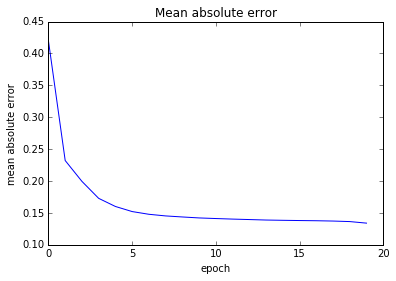

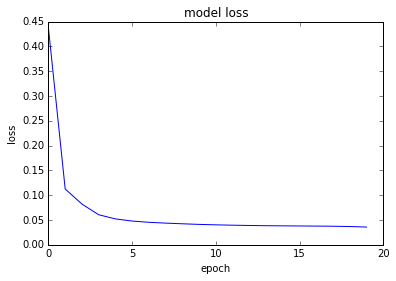

In [10]:
#  "Mean absolute error"
plt.plot(history.history['mean_absolute_error'])
plt.title('Mean absolute error')
plt.ylabel('mean absolute error')
plt.xlabel('epoch')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


In [11]:
rewards = []
observations = []
actions = []
steps_numbers = []
max_steps = env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')
render = False

for i in tqdm(range(num_rollouts)):
    obs = env.reset()
    done = False
    totalreward = 0.
    steps = 0
    while not done:
        action = policy.predict(obs[None, :])
        observations.append(obs)
        actions.append(action)
        obs, reward, done, info = env.step(action)
        totalreward += reward
        steps += 1
        if render:
            env.render()
        if steps >= max_steps:
            break
    steps_numbers.append(steps)
    rewards.append(totalreward)

trained_policy_data = {'observations': np.array(observations),
                'actions': np.array(actions),
                'returns': np.array(rewards),
                'steps': np.array(steps_numbers)}

100%|██████████| 100/100 [00:12<00:00,  7.89it/s]


In [12]:
trained_policy_df = pd.DataFrame(trained_policy_data, columns=['returns', 'steps'])
expert_df = pd.DataFrame(expert_data, columns=['returns', 'steps'])

In [13]:
pd.concat([trained_policy_df, expert_df], axis = 1).describe()

,returns,steps,returns,steps
count,100.000000,100.000000,100.000000,100.0
mean,374.962493,147.300000,3778.679419,1000.0
std,1.966855,0.703526,3.902479,0.0
min,370.898751,146.000000,3769.889129,1000.0
25%,373.764427,147.000000,3775.970157,1000.0
50%,374.545795,147.000000,3779.123108,1000.0
75%,376.701012,148.000000,3781.077802,1000.0
max,380.141276,149.000000,3788.154271,1000.0
